## Imports

In [1]:
import edec.afterprocessing as ap
import edec.preprocessing as pp
import edec.modelling_functions as mo
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Create tin_lists for: train/val/test/test_final

In [2]:
with open('../scripts/dataset_split_dict.pickle', 'rb') as handle:
    datasplit_dict = pickle.load(handle)
tr = datasplit_dict["train"]

In [3]:
#train_tin = datasplit_dict["train"] # Select all train tin
train_tin = ap.get_subset_data(n_failed=44, n_healthy=10)  #Select defined amount

validation_tin = datasplit_dict["validation"]
test_tin = datasplit_dict["test"]
test_final_tin = datasplit_dict["test_final"]

In [15]:
train_parameters = {
            "Sub sample":2,
            "drop_sample":0, # Default 0
            "roll":1         # Default 1 (Must be smaller or equal to subsample)
            }

test_parameters = {
            "Sub sample":2,
            "drop_sample":0, # Default 0
            "roll":1         # Default 1 (Must be smaller or equal to subsample)
            }
 
train_set = ap.create_tin_dataset(db="df.db", parameters=train_parameters, normalize_data=True,
                   show_rundetails=False,tin_list=train_tin)

test_set = ap.create_tin_dataset(db="df.db", parameters=test_parameters, normalize_data=True,
                   show_rundetails=False,tin_list=test_tin)

Run 0 started
54 Unique cars with label 0 has been imported with 10536 subsamples
54 Cars in df
Run 1 started
44 Unique cars with label 1 has been imported with 440 subsamples
44 Cars in df
Run 0 started
2795 Unique cars with label 0 has been imported with 553808 subsamples
2795 Cars in df
Run 1 started
7 Unique cars with label 1 has been imported with 203 subsamples
7 Cars in df


In [29]:
test_set[0][1]

0

In [17]:
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

## Create Network

In [18]:
subsample  = train_parameters["Sub sample"]
subsample

2

In [19]:
class ANNMultilayerperceptron(nn.Module):

    def __init__(self, input_size=(subsample*108),output_size=2, layers=[220,84]):  # 120, 84
        super().__init__()

        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc2b = nn.Linear(layers[1], 500)
        self.fc2c = nn.Linear(500, layers[1])
        self.fc2d = nn.Linear(layers[1], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc2b(X))
        X = F.relu(self.fc2c(X))
        X = F.relu(self.fc2d(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1) # PGA multiclass classification
        #return X

In [20]:
model = ANNMultilayerperceptron()
model

ANNMultilayerperceptron(
  (fc1): Linear(in_features=216, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=84, bias=True)
  (fc2b): Linear(in_features=84, out_features=500, bias=True)
  (fc2c): Linear(in_features=500, out_features=84, bias=True)
  (fc2d): Linear(in_features=84, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [30]:
for b, (X_test,y_test) in enumerate(train_loader):
    break

In [32]:
X_test.shape

torch.Size([10, 2, 108])

In [34]:
model(X_train.view(batch_size, -1)).shape

torch.Size([10, 2])

In [22]:
from ignite.metrics import Precision, Recall
from ignite.metrics import Precision ### LÄGG TILL IGNITE
train_precision = Precision()
train_recall = Recall()

test_precision = Precision()
test_recall = Recall()
# https://pytorch.org/ignite/metrics.html


epochs = 100

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs 

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0 

    # Train

    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Skip iteration if batch size not equal to stated dim
        
            
        #print(X_train.shape, y_train.shape) 
        
        b += 1
        
        y_pred = model(X_train.view(batch_size, -1))  # Flatten input
        lossTrain = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]

        #calculate precision and recall
        train_precision.update((y_pred, y_train))
        train_recall.update((y_pred, y_train))
      

        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        #if b%2 == 0:
           #print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()}")

    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_correct)

    # Test
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_train.view(batch_size, -1))

            predicted = torch.max(y_val.data,1)[1]

            #calculate precision and recall
            test_precision.update((y_val, y_test))
            test_recall.update((y_val, y_test))
            
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(trn_correct)

        if b%5 == 0:
            print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()} Validation Loss: {loss.item()}")


Epoch 0 Batch: 275 Train Loss: 0.7152259945869446 Validation Loss: 0.728594183921814
Epoch 1 Batch: 275 Train Loss: 0.6968151330947876 Validation Loss: 0.7169061899185181
Epoch 2 Batch: 275 Train Loss: 0.6923260688781738 Validation Loss: 0.7032641768455505
Epoch 3 Batch: 275 Train Loss: 0.6866199374198914 Validation Loss: 0.6919437646865845
Epoch 4 Batch: 275 Train Loss: 0.6891058087348938 Validation Loss: 0.6842459440231323
Epoch 5 Batch: 275 Train Loss: 0.6596768498420715 Validation Loss: 0.6667605638504028
Epoch 6 Batch: 275 Train Loss: 0.6899262070655823 Validation Loss: 0.636630117893219
Epoch 7 Batch: 275 Train Loss: 0.6495214700698853 Validation Loss: 0.6469529271125793
Epoch 8 Batch: 275 Train Loss: 0.6147000193595886 Validation Loss: 0.6009319424629211
Epoch 9 Batch: 275 Train Loss: 0.6144102811813354 Validation Loss: 0.6113882064819336
Epoch 10 Batch: 275 Train Loss: 0.5503085851669312 Validation Loss: 0.5960824489593506
Epoch 11 Batch: 275 Train Loss: 0.49308228492736816 Val

In [23]:
print(train_precision.compute())
print(train_recall.compute())
print(test_precision.compute())
print(test_recall.compute())

tensor([0.8966, 0.8605], dtype=torch.float64)
tensor([0.9154, 0.8318], dtype=torch.float64)
tensor([0.9974, 0.0024], dtype=torch.float64)
tensor([0.6420, 0.3448], dtype=torch.float64)


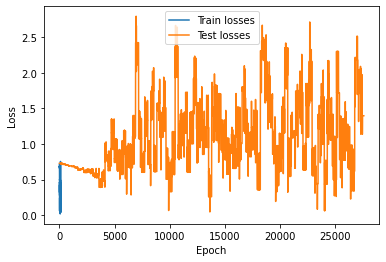

In [24]:
plt.plot(train_losses, label="Train losses")
plt.plot(test_losses, label= "Test losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()